# Assignment

## Training and analyzing Transformer-based NMT models



Imagine that you work for the Foreign Secretary of the United Kingdom and you have to brief the current minister for a high-profile international meeting with their German counterpart. To do so, you will need to review several policy debates at the Bundestag (the lower house of the German federal parliament). However, you do not speak German and there is no current human translator available! But don't panic: you can still develop your own custom neural machine translation (NMT) model specialised in translating German parliamentary debates into English.

In practice, you will need to complete the following tasks:
- train an encoder-decoder Transformer model from scratch on a small dataset containing only short sentences.
- conduct an error analysis of its translations on both shorter and longer sentences, and compare them with those of an NMT model with the same neural architecture but pre-trained on significantly more data.
- implement some standard evaluation metrics and consider how they do (or do not) reflect the kinds of errors you observed.
- visualize the attention weights and analyze the extent to which they can be used to identify different kinds of errors.
- pick one of the possible strategies to improve one of the models, implement it and analyze the results in light of your observations above.

### Setup

First, make sure that you are connected to a GPU runtime. You should see "T4" next to "Connect" on the top right of this page. If not, click on the arrow, select "Change runtime type" and then "T4 GPU". This will ensure that training and testing run faster.

Let's first install and load some relevant libraries: `evaluate` and `sacrebleu` will be useful for scoring the quality of generated translations with respect to a ground-truth reference. `bertviz` will come in handy to inspect attention weights inside the NMT model. `datasets` will allow us to easily download datasets from HuggingFace Hub.

In [69]:
%pip install -q evaluate sacrebleu bertviz sacremoses

In [70]:
import numpy as np
import torch
from tqdm import tqdm

import evaluate
from datasets import load_dataset

from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    MarianMTModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed
)

set_seed(42)

We will then instantiate an encoder-decoder Transformer model based on the [configuration](https://huggingface.co/Helsinki-NLP/opus-mt-de-en/blob/main/config.json) of a popular NMT model, MarianMT. Note that after loading the `tokenizer` and `config`, we do not use `from_pretrained` for our model. This means that its architecture is identical to MarianMT but the parameters are randomly initialised.

Since there is no parallel data available for the Bundestag parliamentary debates, to train and validate our model we will instead rely on the [Europarl](https://opus.nlpl.eu/Europarl/corpus/version/Europarl) dataset, a parallel corpus containing the translations of the proceedings of the European Parliament. We focus on the subset consisting of paired German and English sentences. We curate a version of this dataset with 3 data splits, which contain sentences of certain lengths. The train split (`train_data`) and i.i.d. validation split (`valid_data`) contain sentences of length < 10. In addition, the o.o.d. validation split (`gen_data`) contains sentences of length between 10 and 20 words. This will help us test if our model can also extrapolate to translating longer sequences, as parliamentary debates can be quite long! For this assignment you won't use a test set, as in this fictional scenario it would correspond to the Bundestag debates, for which there are no gold-truth English translations available.

In [71]:
from transformers import MarianMTModel

BASE_MODEL = "Helsinki-NLP/opus-mt-de-en" # we'll train our own model, but we'll use the tokenizer and config from this model!

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
config = AutoConfig.from_pretrained(BASE_MODEL)

# Random initialization - NOT loading pretrained weights
model = MarianMTModel(config)

train_data = load_dataset("EdinburghNLP/europarl-de-en-mini", split="train") # we'll train on europarl sentences of length < 10.
valid_data = load_dataset("EdinburghNLP/europarl-de-en-mini", split="validation")
gen_data = load_dataset("EdinburghNLP/europarl-de-en-mini", split="gen_val") # length generalization data (length 10-20).

Just so you can get a sense of the model architecture and a sample of the training data, let's print them both in the cell below:

In [72]:
print(model)
for example in train_data[:10]['translation']:
    print(example)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

Next, let's postprocess these datasets to tokenize the sentence pairs in the source (German) and target (English) languages.

In [73]:
def create_preprocess_function(tokenizer):
  # global variables are bad! the preprocess function needs the tokenizer and the examples.
  def preprocess_function(examples):
      """Preprocess the data."""
      inputs = [ex["de"] for ex in examples["translation"]]
      targets = [ex["en"] for ex in examples["translation"]]
      model_inputs = tokenizer(
          inputs, text_target=targets, return_tensors="pt", padding=True
      )
      return model_inputs
  return preprocess_function

train_data = train_data.map(create_preprocess_function(tokenizer), batched=True)
valid_data = valid_data.map(create_preprocess_function(tokenizer), batched=True)
gen_data = gen_data.map(create_preprocess_function(tokenizer), batched=True)



In [74]:
print(train_data[0])
print(train_data[1])

{'translation': {'de': '(Beifall)', 'en': '(Applause)'}, 'input_ids': [20, 38406, 27, 0, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [20, 45914, 27, 0, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100]}
{'translation': {'de': 'Deswegen, versprühen Sie das europäische Lebensgefühl!', 'en': 'So make Europe come alive in people’s minds!'}, 'input_ids': [19441, 2, 258, 35559, 15, 42, 44, 2994, 1960, 13343, 68, 0, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 58100, 5810

### Exercise 1: Training your model (15 marks)

Your first task is to execute the code below to train your NMT model on the train split of the Europarl dataset.

Note that the hyper-parameters for training (e.g., batch size and learning rate) and the frequency of logging/saving/evaluating the model are provided as arguments of `Seq2SeqTrainingArguments`. The meaning of each argument is explained with in-line comments; you can find more details in the [official library documentation](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

During training, the `Seq2SeqTrainer` will report the losses for train, i.i.d. validation, and o.o.d. validation splits in the form of a table. Optionally, you can decide if you want to also log the metrics to the project specified by the `WANDB_PROJECT` environment variable. When prompted, follow the instructions to provide your WandB token (similar to Lab 3). To enable WandB logging, set `report_to` to `"wandb"`; to disable WandB, set the same argument to `[]`.

A checkpoint of your model will be saved on your Colab instance at the directory specified as `output_dir` (click on the folder icon in the left sidebar to navigate there).

**Important**: the models in `output_dir` are deleted every time you reload Colab. After training, make sure to compress it with the command `!zip -r my-de-en-nmt.zip my-de-en-nmt` and either dowload a copy on your laptop or move it to your Google Drive with `!cp my-de-en-nmt.zip /content/drive/MyDrive/` after [connecting your notebook to your Google Drive](https://stackoverflow.com/questions/47744131/colaboratory-can-i-access-to-my-google-drive-folder-and-file). This will allow you to reload the zip file for the subsequent exercises if you need to reload Colab for any reason. To unzip the reloaded zip file, you can use `!unzip my-de-en-nmt.zip`. Allow a few minutes for each step of this process.

Now execute the code below to train your model! You can expect training to take approximately 45 minutes on a T4 GPU. Please don't close your browser or
disconnect from your internet connection as training may stop.

In [75]:
import os

NUM_EPOCHS = 5
BATCH_SIZE = 128

os.environ["WANDB_PROJECT"] = "anlp-assignment"  # name your W&B project

training_args = Seq2SeqTrainingArguments(
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    auto_find_batch_size=True,                # Adjust batch size automagically based on available memory
    output_dir='my-de-en-nmt',                # Specify where the model is saved
    save_total_limit=1,
    predict_with_generate=False,              # Do not calculate extrinsic metrics
    logging_steps=20,                         # Log metrics to WandB this often
    save_steps=500,                           # Save model this often
    eval_steps=500,                           # Evaluate model this often
    eval_strategy="steps",
    fp16=torch.cuda.is_available(),           # Use half precision for training if on GPU
    fp16_full_eval=True,                      # Use half precision during evaluation
    group_by_length=True,                     # Group examples by length to minimise padding
    generation_max_length=20,                 # Maximum number of tokens generated
    #report_to="wandb",                       # Report metrics to WandB if that helps...
    report_to=[],                             # ...or not, if you prefer
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset={"val": valid_data, "gen": gen_data},
    data_collator=data_collator,
)

In [76]:
# Train the model
trainer.train()

# Save the model
trainer.save_model()

Step,Training Loss,Validation Loss,Val Loss,Gen Loss
500,1.694600,No log,1.998478,2.891627
1000,1.428400,No log,1.701959,2.609508
1500,1.333700,No log,1.560349,2.525847
2000,1.229300,No log,1.467148,2.515838
2500,1.200900,No log,1.382692,2.439160
3000,1.105500,No log,1.324225,2.406037
3500,1.057800,No log,1.281332,2.404095
4000,1.064300,No log,1.236030,2.466142
4500,1.041700,No log,1.202539,2.379280
5000,0.995100,No log,1.172893,2.362744


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


**In your report**: Plot the losses for each of the 3 splits across training steps and briefly discuss their relationship and their trends. Your answer should include what you would expect to see if the model is training correctly and fully, and what the plots actually indicate.

(Note: regardless of whether you think the model *could* be trained better, please use the model trained with the provided hyperparameters for the remainder of the assignment. This will make your results comparable with the other groups.)

**Page limit: half a page** (Half pages are marked with lines in the report template.)

### Exercise 2: Error Analysis (25 marks)

The losses in the i.i.d. and o.o.d. splits give you a sense of the overall ability of your NMT model to generalise to new examples. However:
- these losses only show the negative log probability the model assigns to the correct translation. This is not necessarily equivalent to measuring the model's ability to *generate* such translations.
- moreover, these losses do not inform you about the types of errors present in your model's translations.

Hence, you decide to conduct a more **fine-grained error analysis**, by comparing the model prediction in English with the ground-truth reference in English.

In addition, you decide to compare your model's translations with those of a pretrained model. The pretrained model has the exact same architecture as yours but is trained on a mixture of texts from different genres (i.e., it is not specialised for parliamentary discussion) and on significantly more data.

After some thinking, you come up with the following taxonomy of error types.

- *Omission*: content present in source (and reference translation) missing in model translation.
- *Addition/Hallucination*: content not supported by source.
- *Grammaticality/Fluency*: ungrammatical English or awkward phrasing.
- *Named Entities/Numbers/Punctuation*: wrong, dropped, or malformed NEs, numerals, list markers, or brackets.
- *Incompleteness/Truncation*: translation ends prematurely or degenerates.
- *Idioms/Formulae/Register*: failure to render fixed expressions, salutations, idioms, or formal register.

**Your tasks** First, fill in the code at `### FILL IN YOUR CODE` to obtain the model `translations` from both models (the one you trained and the pre-trained one). `translations` is a list of strings (each string being the translation for an example). Then, consider the translations from each model for the first 25 examples in each validation split (i.i.d. and o.o.d.). By comparing the references and model predictions, try to annotate each example according to the error types listed above. Note that a single translation may have multiple error types. You may also find it hard to decide how to categorize certain errors (which is almost always true when annotating data). If so, take note of these cases to discuss in your report.

**In your report:** Briefly discuss the results of your annotation. In particular, give 1-2 clear examples of each of the error types (from any of the model–split combinations), and also provide examples that you were not sure how to annotate. If the same type of ‘difficult’ case happened several times, would you propose adding a new error type, or just improving the annotation guidelines? Finally, using your annotated examples, plot the distribution of error types for each model-split combination and briefly discuss what you think is the reason for the most frequent kinds of errors in each of the 4 model–split combinations.

**Page limit: one and a half pages**


In [77]:
BATCH_SIZE = 128

def eval(dataset, model, gen_config=None, metrics=None):
    """
    dataset is one of the two splits: valid_data, gen_data
    model is one of the two models: yours or pretrained
    gen_config is a dictionary of arguments for model.generate()
    metrics is a dictionary of functions to compute metrics
    """

    results = []

    if gen_config is None:
        gen_config = {
            "max_length": 20,
            "num_beams": 4,
            "early_stopping": True,
        }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []

    for batch in tqdm(dataset.batch(BATCH_SIZE)):

        ### FILL IN YOUR CODE
        input_ids = torch.tensor(batch["input_ids"])
        attention_mask_batch = torch.tensor(batch["attention_mask"])
        translations = model.generate(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask_batch.to(device),
            **gen_config
        )
        translations = tokenizer.batch_decode(translations, skip_special_tokens=True)

        for i in range(len(translations)):
            all_predictions.append(translations[i])
            all_labels.append(batch['translation'][i]['en'])

            example_metrics = {
                    "input": batch["translation"][i]["de"],
                    "prediction": translations[i],
                    "reference": batch["translation"][i]["en"],
                }

            results.append(
                example_metrics
            )

    global_metrics = {}
    if metrics is not None:
        for metric_name, metric_func in metrics.items():
            global_metrics[metric_name] = metric_func(all_predictions, all_labels)

    return results, global_metrics

In [78]:
models = {"my": "my-de-en-nmt", "pretrained": "Helsinki-NLP/opus-mt-de-en"}
datasets = {"i.i.d.": valid_data, "o.o.d.": gen_data}
metrics = {}

# For now, we use the default generation configuration and do not evaluate metrics
# This is just to obtain the model translations
all_results = {}
for a, model_name in models.items():
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, attn_implementation='eager')
    for b, dataset in datasets.items():
        print(f"Evaluating {a} model on {b} split")
        results, global_metrics = eval(dataset, model, metrics=metrics)
        all_results[f"{a} {b}"] = results

Evaluating my model on i.i.d. split


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Evaluating my model on o.o.d. split


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Evaluating pretrained model on i.i.d. split


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Evaluating pretrained model on o.o.d. split


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


In [79]:
print(list(all_results.items())[0][1][0])

{'input': 'Europa verfügt über ein großes Potenzial an erneuerbarer Energie.', 'prediction': 'Europe has a great potential for energy energy.', 'reference': 'In Europe, we have a vast renewable energy potential.'}


In [80]:
import pandas as pd

for title, results in all_results.items():
    print(f"--- {title} ---")
    results_df = pd.DataFrame(results)

    # Filter for examples with at least 5 words in the input
    results_df_filtered = results_df[results_df['input'].str.split().str.len() >= 5]

    print("\nFirst 25 translations:")
    # Check if there are enough examples after filtering
    if len(results_df_filtered) >= 25:
        for index, row in results_df_filtered.head(25).iterrows():
            print(f"Input: {row['input']}")
            print(f"Prediction: {row['prediction']}")
            print(f"Reference: {row['reference']}\n")

--- my i.i.d. ---

First 25 translations:
Input: Europa verfügt über ein großes Potenzial an erneuerbarer Energie.
Prediction: Europe has a great potential for energy energy.
Reference: In Europe, we have a vast renewable energy potential.

Input: Kommissar Verheugen stimmte dieser Forderung bei der gestrigen Aussprache zu.
Prediction: Commissioner Verheugen's request for this debate.
Reference: Commissioner Verheugen endorsed this demand during yesterday's debate.

Input: Welcher Empfang wird diesen Menschen bereitet?
Prediction: What peoples are going to do with these people?
Reference: What reception will be given to these people?

Input: Alle Ausnahmen werden mit einer Mehrheit von 75 % beschlossen.
Prediction: Everyone will take a majority of a majority of %.
Reference: Any exceptions shall be approved with 75 % support.

Input: Ihr solltet dasselbe tun wie wir!'
Prediction: You should do the same as we do!'
Reference: You should do as we have done!'

Input: Mit solcher Untätigkei

### Exercise 3: Evaluation Metrics (15 marks)

After having inspected the translations and performed an error analysis, you should develop an appropriate set of extrinsic metrics for your models' generation. Specifically, you decide to focus on the following metrics:

- *BLEU*: A machine translation metric based on modified n-gram (typically 1–4) precision against one or more references, combined via a geometric mean and a brevity penalty. It rewards exact n-gram overlap, which can under-value valid paraphrases; smoothing is often used for short sentences.

- *ChrF*: A character n-gram F-score that combines precision and recall of character n-grams (commonly with β=2, i.e., chrF2). It is language- and tokenization-agnostic, capturing morphology and minor spelling variants better than word-level metrics.

- *Length ratio* (|y|/|x| by whitespace tokens): The ratio of the number of whitespace-delimited tokens in the output y to the source x. It’s a simple diagnostic for verbosity/compression (values >1 mean longer outputs) but can be misleading across languages or with different tokenization schemes.

- *Bigram repetition rate*: The proportion of bigrams in a generated text that repeat, i.e., 1 − (# unique bigrams / # total bigrams). For text with less than 3 tokens, this metric should return a value of 0. Higher values signal degenerative looping or redundancy; it flags repetition but does not measure semantic quality.

Each of these metrics is computed at the dataset level.

**In the code below**: implement the 4 metrics described above. For BLEU and ChrF, you should use the default implementations and hyperparameters provided by [`evaluate`](https://huggingface.co/evaluate-metric/spaces). For Length ratio and Bigram repetition rate, you should implement them with `numpy`.

**In your report**: First, compute the value of these metrics for both models and both datasets. Report their values, then briefly discuss them. You may want to include the following points in your discussion:
- Which metrics show similar trends and why?
- Which of the error types in the Exercise 2 taxonomy can each metric capture?

If you find anything else of note, feel free to include it in your answer.

**Page limit: one page**

In [81]:
def bleu_func(all_predictions, all_labels):
    bleu = evaluate.load("sacrebleu")
    return bleu.compute(predictions=all_predictions, references=all_labels)["score"]

def chrf_func(all_predictions, all_labels):
    chrf = evaluate.load("chrf")
    return chrf.compute(predictions=all_predictions, references=all_labels)["score"]

def lenr_func(all_predictions, all_labels):
    lenrs = []
    for pred, label in zip(all_predictions, all_labels):
        lenrs.append(len(pred.split()) / len(label.split()))
    return sum(lenrs) / len(lenrs)

def repr_func(all_predictions, all_labels):
    repr_rates = []
    # iterate over each prediction
    for pred in all_predictions:
      # get all bigrams
      bigrams = [pred[i:i+2] for i in range(len(pred)-1)]
      # count repr rate for bigrams
      if len(bigrams) == 0:
        repr_rate = 0
      else:
        repr_rate = len(set(bigrams)) / len(bigrams)
      repr_rates.append(repr_rate)
    return sum(repr_rates) / len(repr_rates)


In [82]:
models = {"my": "my-de-en-nmt", "pretrained": "Helsinki-NLP/opus-mt-de-en"}
datasets = {"i.i.d.": valid_data, "o.o.d.": gen_data}
metrics = {"bleu": bleu_func, "chrf": chrf_func, "lenr": lenr_func, "repr": repr_func}

all_results = {}
for a, model_name in models.items():
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, attn_implementation='eager')
    for b, dataset in datasets.items():
        print(f"Evaluating {a} model on {b} split:")
        results, global_metrics = eval(dataset, model, metrics=metrics)
        print(global_metrics)
        all_results[f"{a} {b}"] = results

Evaluating my model on i.i.d. split:


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


{'bleu': 29.13223173626576, 'chrf': 47.304976362611484, 'lenr': 1.0190277777777779, 'repr': 0.8433067533407154}
Evaluating my model on o.o.d. split:


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


{'bleu': 9.429003352860573, 'chrf': 30.823547846756792, 'lenr': 0.597072342595485, 'repr': 0.8232244943916597}
Evaluating pretrained model on i.i.d. split:


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


{'bleu': 41.06542157703987, 'chrf': 62.34375994146468, 'lenr': 1.0205484126984126, 'repr': 0.8743644497260883}
Evaluating pretrained model on o.o.d. split:


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


{'bleu': 34.75110542211436, 'chrf': 58.54457796349257, 'lenr': 0.9346844168817079, 'repr': 0.7776996393416171}


### Exercise 4: Attention coverage (25 marks)

You've seen that sometimes the translation model doesn't include all the information from the source sequence in its predicted translation, a phenomenon known as *under-translation*. It's been claimed that a symptom of under-translation is the lack of "attention coverage". The idea behind attention coverage is that to correctly translate a source sentence, a model should attend strongly on each of its tokens at least once. This exercise explores that claim.

**In the code below**: implement an estimator of attention coverage, `attention_coverage_stats`. This function takes the model, tokenizer, source sentences, predicted sentences, a threshold for low coverage (0.2 in this case), and a batch size as input. For each example, it should extract the cross-attention weights from the last layer of the decoder. It should then calculate the coverage for each source sentence token by taking the maximum attention weight over all heads and target sentence positions. After excluding padded tokens, it should calculate the fraction of source tokens with coverage below the specified threshold. It should then create `low_frac_list`, a list containing such a fraction for each example.

Once you've done that, the provided code will plot the distribution of attention coverage for each model-split combination.


**In your report**: Discuss the relationship of attention coverage with errors types and metrics that indicate under-translation. Overall, do you find support for the claim that attention coverage is useful for identifying instances of under-translation when a reference is not available? Your answer should include plots of the distribution of attention coverage (you can use our code for this, or modify it if you wish), and may also include specific examples (e.g. visualizations with `bertviz` introduced in Lab 4), or results from earlier questions. Do not assume the marker will see (or has seen) your answers to previous questions; make this answer self-contained.

**Page limit: one and a half pages**

Coverage (my i.i.d.): 0.046


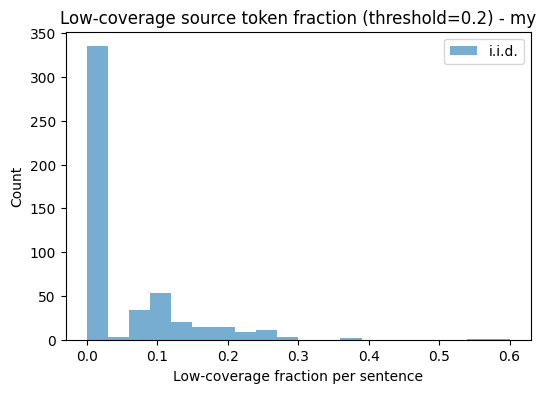

Coverage (my o.o.d.): 0.210


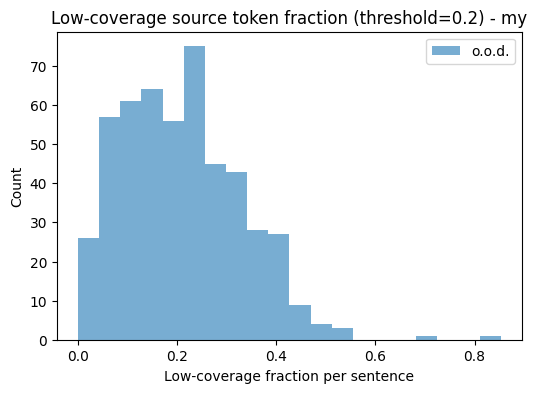

Coverage (pretrained i.i.d.): 0.030


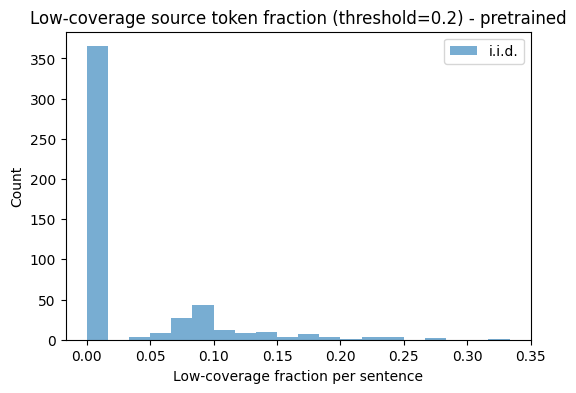

Coverage (pretrained o.o.d.): 0.056


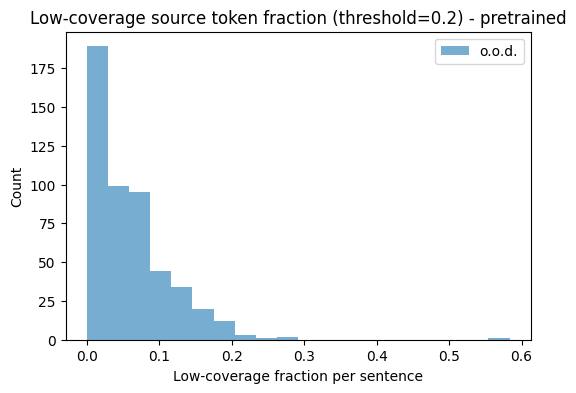

In [177]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def attention_coverage_stats(model, tokenizer, sources, targets, threshold=0.2, batch_size=BATCH_SIZE):
    low_frac_list = []

    # iterate over each source sentence and prediction (example)
    for source, target in zip(sources, targets):
      # extract the cross-attention weights from last layer of decoder
      inputs = tokenizer(source, return_tensors="pt").to(device)
      outputs = model.generate(
          **inputs,
          output_attentions=True,
          return_dict_in_generate=True,
          num_beams=1,
      )

      # tuple of tuples of torch.FloatTensors, 1 for each layer:
      # (batch_size, num_heads, sequence_length, sequence_length)

      # stack over each time step
      cross_attn_all = torch.cat(
        [step_attns[-1] for step_attns in outputs.cross_attentions],
        dim=2,
      )

      # print(cross_attn_all.shape)
      batch_size, num_heads, target_len, source_len = cross_attn_all.shape

      max_over_targets = cross_attn_all.max(dim=2)
      max_over_heads = max_over_targets.values.max(dim=1)
      # print(max_over_heads)
      # print(max_over_heads.values.shape)
      # excluding padded tokens, calculate fraction of source tokens
      # with coverage below threshold (mask is always 1's)
      below = max_over_heads.values < threshold

      low_frac = below.sum() / source_len
      low_frac_list.append(low_frac.item())
      # print(low_frac.item())
      # print(f"Low frac: {low_frac}")
      # if count > 10:
      #   return
      # count +=1

    return np.array(low_frac_list)

models = {"my": "my-de-en-nmt", "pretrained": "Helsinki-NLP/opus-mt-de-en"}
datasets = {"i.i.d.": valid_data, "o.o.d.": gen_data}
metrics = {"bleu": bleu_func, "chrf": chrf_func, "lenr": lenr_func, "repr": repr_func}

for model_name, model_path in models.items():
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path, attn_implementation='eager').to(device)
    for split, _ in datasets.items():
        sources = [example['input'] for example in all_results[f"{model_name} {split}"]]
        predictions = [example['prediction'] for example in all_results[f"{model_name} {split}"]]
        low_frac = attention_coverage_stats(model, tokenizer, sources, predictions, threshold=0.2)

        print(f"Coverage ({model_name} {split}): {low_frac.mean():.3f}")

        plt.figure(figsize=(6,4))
        plt.hist(low_frac, bins=20, alpha=0.6, label=split)
        plt.title(f"Low-coverage source token fraction (threshold=0.2) - {model_name}")
        plt.xlabel("Low-coverage fraction per sentence")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

In [178]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
src = '/content/my-de-en-nmt'   # the folder in Colab
dst = '/content/drive/MyDrive/my-de-en-nmt'  # destination on Google Drive

# Copy entire folder recursively
shutil.copytree(src, dst, dirs_exist_ok=True)

print(f"✅ Folder saved to {dst}")


Mounted at /content/drive
✅ Folder saved to /content/drive/MyDrive/my-de-en-nmt


### Exercise 5: Improving your model (20 marks)

Now that you have completed a thorough evaluation, you would like to improve your model's translation quality, including generalizing to longer sentence lengths and avoiding degenerate decoding behaviors. There are many ways you could potentially do this, but for this question we would like you to choose **exactly one** of the following options:

1) Explore different sampling strategies for decoding.

OR

2) Explore relative position encoding instead of abolute position encoding.

Each option is described in slightly more detail below.

**In the report**:
Briefly report on your experiments. Which option did you choose, and what did you expect to find? That is, which aspects of model performance did you expect to improve, and why? What did you actually find? Were there any downsides to you changes? *Note*: You do not need to demonstrate an actual improvement in order to do well on this question; rather you need to demonstrate careful thinking and experiments.

**Page limit: one page**

**Warning:** If you have struggled with the coding in the previous questions, or have spent a lot of time already on the assignment, we encourage you to pursue Option 1. Option 2 is more challenging to implement in Huggingface `transformers`, so a strong answer to it can receive more marks than a strong answer to Option 1. However, simply implementing a solution to Option 2 is not sufficient to do well on this question: the mark is largely based on your discussion and analysis. Therefore, a strong answer to Option 1 will still do better than a weak answer to Option 2.

### Option 1

Explore different sampling strategies to determine if these benefit the translation quality. These should include, at the very least:

- *Beam size*: In beam search decoding for encoder–decoder models, beam size is the number of partial hypotheses kept at each step. Larger beams explore more options and can improve quality up to a point, but cost grows roughly linearly and they can sometimes reduce diversity or favor safe/short answers; beam size 1 is greedy decoding.

- *Length penalty*: Because sequence probabilities multiply token probabilities, raw likelihood favors short outputs; a length penalty rescales scores to counter this bias. The final beam scores are normalised as score = log P(y) / (len(y) ** length_penalty). Values > 1.0 encourage longer outputs; < 1.0 favor shorter ones.

*Hint:* You can implement these by passing in hyperparameters using the `gen_config` argument during evaluation.

### Option 2

Switch from the original sinusoidal embeddings of Marian MT (absolute position encoding) to relative position encoding, as it may generalise better to longer sequence lengths. Specifically, use *strictly* one of T5-style learned relative position encoding, ALiBi, or RoPE.

*Hint*: There are various ways to implement this, some easier than others. You may use/adapt code from existing model implementations, but if you do, please note it in your report. You will need to re-train your model in order to get your modification to work.